<a href="https://colab.research.google.com/github/manycoding/signatures-detection/blob/master/AutoML_vision_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to use trained Google AutoML model for inference both with cloud and locally.

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install -U -q git+https://github.com/fastai/fastai

Updating fastai...
Done.


In [0]:
# !pip install -U -q google-cloud-vision
!pip install --upgrade -q google-cloud-automl
# !pip install -U -q tensorflow

     |████████████████████████████████| 378kB 2.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%env GOOGLE_APPLICATION_CREDENTIALS=/content/gdrive/My Drive/Colab Notebooks/Fastai V3-5166ae7dfaf6.json
!gcloud auth activate-service-account --key-file="/content/gdrive/My Drive/Colab Notebooks/Fastai V3-5166ae7dfaf6.json"

# Cloud Model

In [0]:
%env PROJECT_ID=fastai-v3-233512

env: PROJECT_ID=fastai-v3-233512


In [0]:
# import getpass

# APIKEY = getpass.getpass()

In [0]:
from google.cloud import automl_v1beta1
from google.cloud.automl_v1beta1.proto import service_pb2

In [0]:
project_id = "fastai-v3-233512"
model_id = "IOD842502983806615552"

In [0]:
# The name of the image file to annotate
# file_path = os.path.abspath('/content/craig menon australia driver license.jpg')
file_path = home/"dataset/3-2020-02-18T16:50:59.947Z.png"

In [0]:
# 'content' is base-64-encoded image data.
def get_prediction(image_path, project_id, model_id):
  prediction_client = automl_v1beta1.PredictionServiceClient()

  name = f'projects/{project_id}/locations/us-central1/models/{model_id}'
  with open(image_path, 'rb') as ff:
      content = ff.read()
  payload = {'image': {'image_bytes': content }}
  params = {}
  request = prediction_client.predict(name, payload, params)
  return request

In [0]:
get_prediction(home/"dataset/3-2020-02-18T16:50:59.947Z.png", project_id, model_id)

FailedPrecondition: ignored

# Tensorflow

In [0]:
from pathlib import Path
from fastai import *
from fastai.vision import *

import tensorflow as tf

root_dir = Path("/content/gdrive/My Drive/")
home = root_dir/"fastai/Business Cards/"
home.mkdir(parents=True, exist_ok=True)

In [0]:
!gsutil cp -r gs://automl_models_bce/model-export/iod/* "{home}/tf/"

Copying gs://automl_models_bce/model-export/iod/tf_js-business_cards_ed_20200218023824-2020-02-20T12:56:59.165Z/dict.txt...
Copying gs://automl_models_bce/model-export/iod/tf_js-business_cards_ed_20200218023824-2020-02-20T12:56:59.165Z/group1-shard1of3.bin...
Copying gs://automl_models_bce/model-export/iod/tf_js-business_cards_ed_20200218023824-2020-02-20T12:56:59.165Z/group1-shard2of3.bin...
Copying gs://automl_models_bce/model-export/iod/tf_js-business_cards_ed_20200218023824-2020-02-20T12:56:59.165Z/group1-shard3of3.bin...
\ [4 files][  9.8 MiB/  9.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://automl_models_bce/model-export/iod/tf_js-business_cards_ed_20200218023824-2020-02-20T12:56:59.165Z/model.json...
Copying g

In [0]:
labels = pd.read_csv(home/"dataset/cards_labels.csv", header=None);
labels.head()

0                                                  1   ...        9         10
0  TRAIN  gs://business_cards/dataset/029-2020-02-17T19:...  ...  0.112545  0.608323
1  TRAIN  gs://business_cards/dataset/029-2020-02-17T19:...  ...  0.109677  0.534884
2  TRAIN  gs://business_cards/dataset/029-2020-02-17T19:...  ...  0.111828  0.669523
3  TRAIN  gs://business_cards/dataset/055-2020-02-17T19:...  ...  0.082748  0.253366
4  TRAIN  gs://business_cards/dataset/055-2020-02-17T19:...  ...  0.552693  0.276622

[5 rows x 11 columns]

In [0]:
# valid test names
test_names = labels[labels[0] != "TRAIN"][1].apply(lambda x: x.split("/")[-1]).unique()
train_names = labels[labels[0] == "TRAIN"][1].apply(lambda x: x.split("/")[-1]).unique()

In [0]:
model_dir = home/"tf/tf_saved_model-business_cards_ed_20200218023824-2020-02-19T20:15:50.773Z"

def get_preds(file_names):
    with tf.Session(graph=tf.Graph()) as s:
        preds = []
        tf.saved_model.load(s, ['serve'], str(model_dir))
        for tn in file_names:
            f = Path(home/f"dataset/{tn}")
            if f.is_dir():
                continue
            with open(f, "rb") as img_file:
                raw_img = img_file.read()
                y_pred = (s.run("Postprocessor/convert_scores:0", feed_dict={"encoded_image_string_tensor:0": [raw_img]}),
                        s.run("Postprocessor/Decode/transpose_1:0", feed_dict={"encoded_image_string_tensor:0": [raw_img]}))
                #y,x,y2,x2
                preds.append([f, y_pred])
    return preds

In [0]:
classes = np.array(["background", "title", "name", "company"])

def show_preds(preds, threshold = 0.5):
    for p in preds:
        img = open_image(p[0])
        activations = np.argmax(p[1][0][0], axis=0)
        coordinates = p[1][1]
        bboxes = coordinates[activations].copy()
        bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * img.size[0]
        bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * img.size[1]
        bboxes = bboxes[1:]
        thrs_ids = []
        # for i, a in enumerate(activations[1:]):
        #     thrs_ids.append(p[1][0][0][a][i])
        # clss = []
        # for i, c in enumerate(classes[1:]):
        #     clss.append(f"{c} {thrs_ids[i]:.2f}")
        bbox = ImageBBox.create(*img.size, bboxes=bboxes, labels=list(range(len(bboxes))), classes=classes[1:])
        img.show(y=bbox, figsize=(9,7))

In [0]:
# show_preds(preds[:5])

In [0]:
# test_preds = get_preds(test_names)

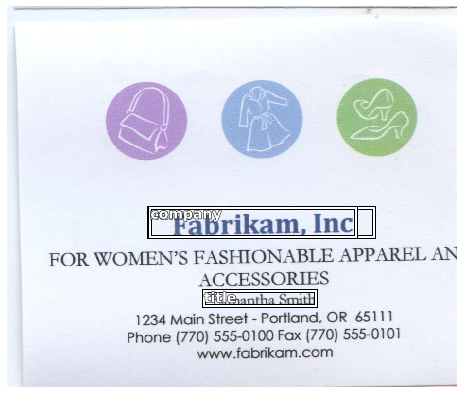

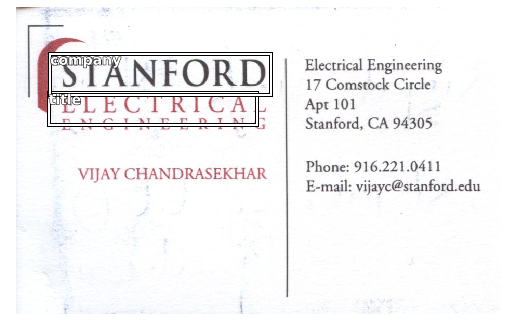

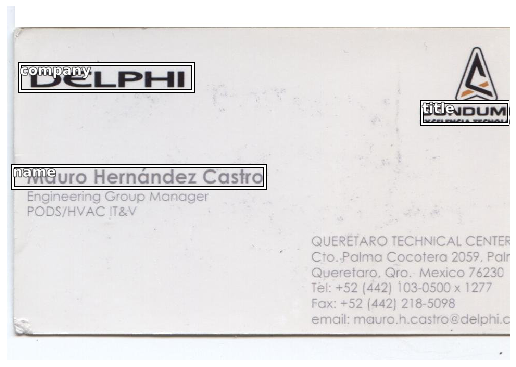

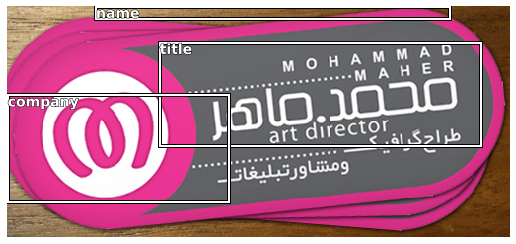

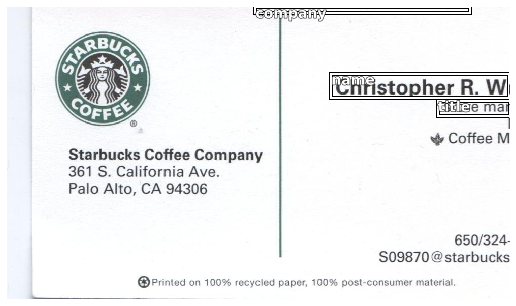

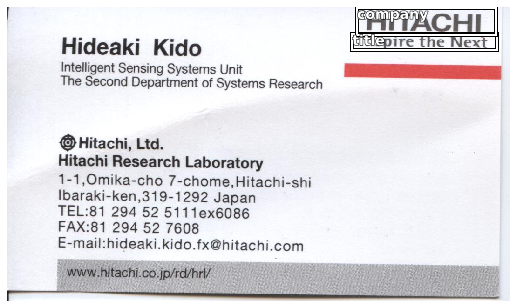

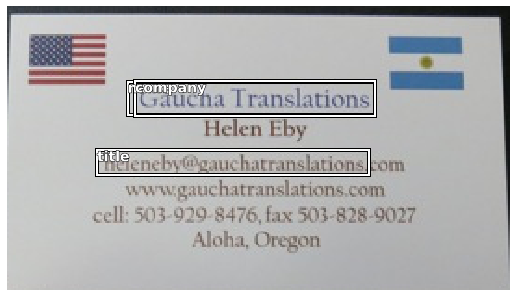

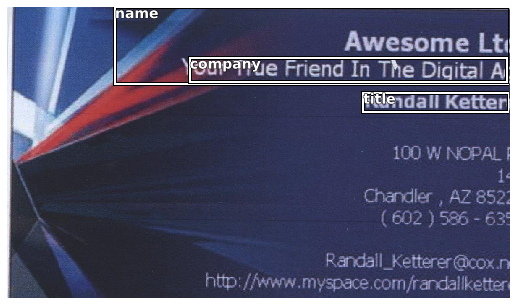

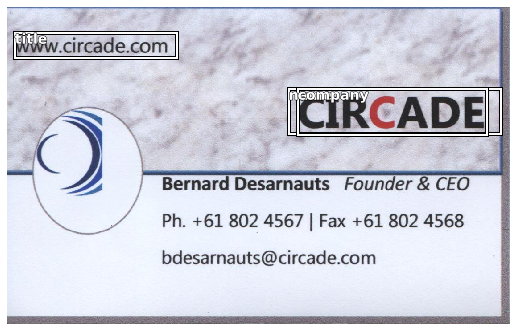

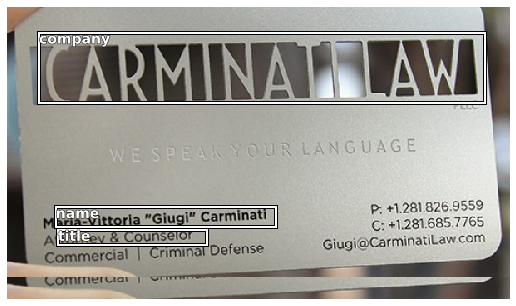

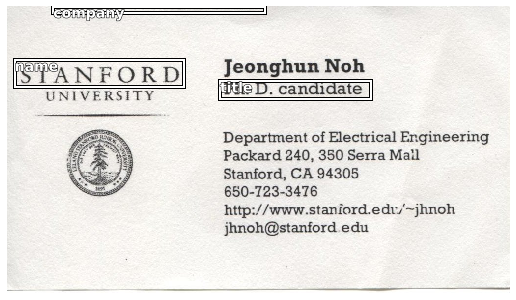

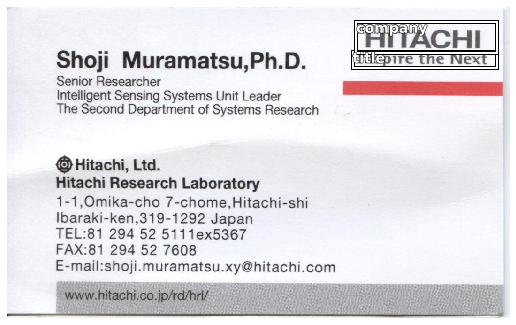

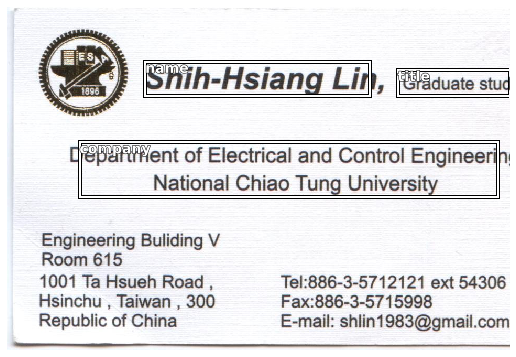

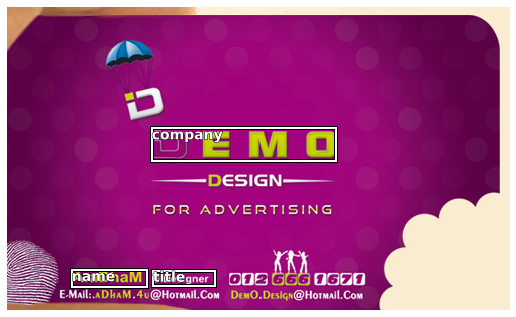

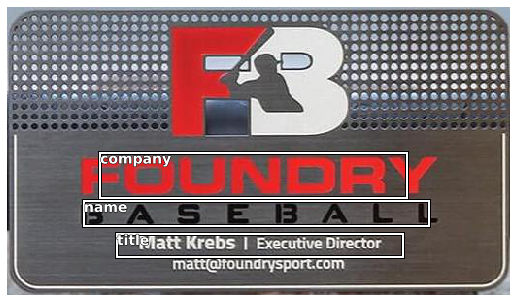

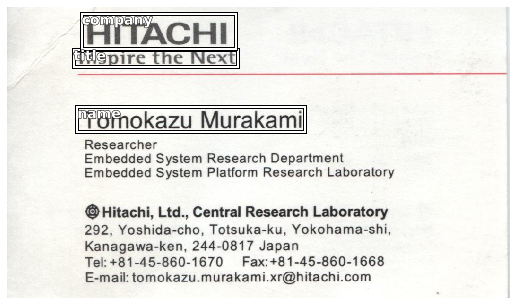

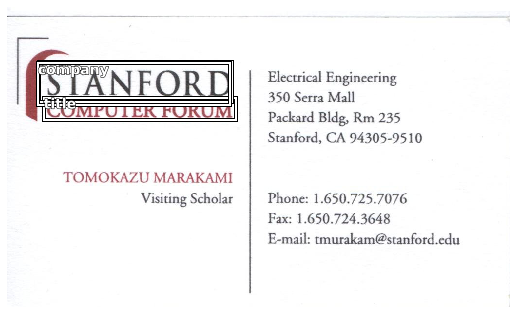

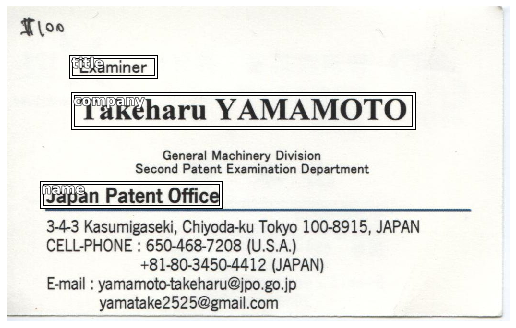

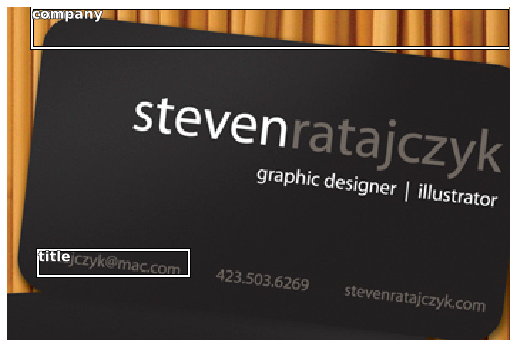

In [0]:
show_preds(test_preds)

companies: 13/18

names: 6/19

titles: 8/15


In [0]:
#companies, names, titles
13/18, 6/19, 8/15

(0.7222222222222222, 0.3157894736842105, 0.5333333333333333)

In [0]:
#false positives companies, names, titles
5/18, 5/19, 11/15

(0.2777777777777778, 0.2631578947368421, 0.7333333333333333)